In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33065")
client

<Client: 'tcp://127.0.0.1:33065' processes=8 threads=40, memory=157.36 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:33065' processes=0 threads=0, memory=0 B>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
import gcm_filters
import gsw
import xrft
import s3fs
import os.path as op
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
sdir = '/tank/spectre/tuchida/MLI/'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

# eNATL60

In [5]:
reg = 2
dsi = cat.eNATL60(region=str(reg),datatype='interior_daily', season='fma'
                 ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),
                                  depthu=slice(None,-1)
                                 ).chunk({'deptht':5,'depthw':5,
                                          'depthv':5,'depthu':5}
                                        )
dsi

<xarray.Dataset>
Dimensions:       (y: 735, x: 607, deptht: 106, depthu: 106, depthv: 106,
                   depthw: 107, time_counter: 89)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 607), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 607), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 607), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 607), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 607), meta=np.ndarray>

In [6]:
YC = dsi.lat.mean('x')
XC = dsi.lon.mean('y')
YG = xr.concat([YC[0]-YC.diff('y').min(skipna=True),
                .5*(YC[1:] + YC[:-1])
               ],'y')
XG = xr.concat([XC[0]-XC.diff('x').min(skipna=True),
                .5*(XC[1:] + XC[:-1])
               ],'x')

In [7]:
CT = xr.DataArray(dsi.votemper.data, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )
SA = xr.DataArray(dsi.vosaline, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )

In [8]:
ds = CT.to_dataset(name='CT')
ds['SA'] = SA

ds['maskC'] = xr.DataArray(dsi.tmask.data, dims=['Z','YC','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XC':XC.data}
                          )
ds['maskW'] = xr.DataArray(dsi.umask.data, dims=['Z','YC','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XG':XG.data}
                          )
ds['maskS'] = xr.DataArray(dsi.vmask.data, dims=['Z','YG','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XC':XC.data}
                          )
ds['maskG'] = xr.DataArray(dsi.fmask.data, dims=['Z','YG','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XG':XG.data}
                          )

coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        "Z": {"center": "Z",  }
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z

In [9]:
sig0 = xr.apply_ufunc(gsw.sigma0, ds.SA, ds.CT,
                      dask='parallelized', output_dtypes=[float,]
                     )
z10 = 6   # grid index of ~10m depth
nMLD = (z10 
        + np.abs((sig0.isel(Z=slice(z10,-1)).fillna(0.)
                  - sig0.isel(Z=z10).fillna(0.)
                 ) - .03
                ).reset_coords(drop=True).argmin(dim='Z').compute()
       )  # indexing needs loading
MLD = (xr.ones_like(sig0.isel(Z=slice(None,-1))) 
       * ds.Z).reset_coords(drop=True)[{'Z':nMLD}].reset_coords(drop=True)
MLD

<xarray.DataArray (time: 89, YC: 735, XC: 607)>
dask.array<reshape, shape=(89, 735, 607), dtype=float64, chunksize=(89, 735, 607), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 30.5 30.52 30.53 30.55 ... 40.37 40.38 40.4 40.41
  * XC       (XC) float32 -53.56 -53.54 -53.53 -53.51 ... -43.48 -43.46 -43.44
Dimensions without coordinates: time

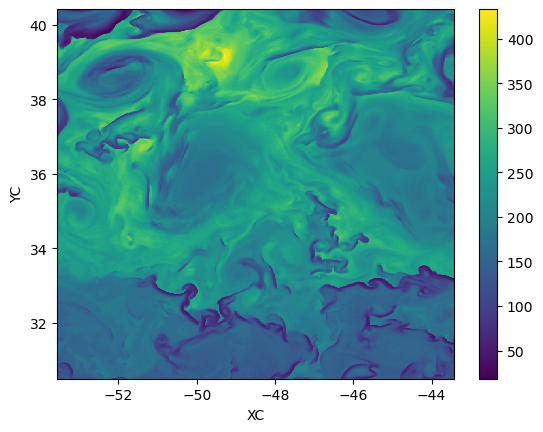

In [11]:
MLD.isel(time=0).plot()

In [10]:
MLD.to_dataset(name='H'
              ).chunk({'time':3,'YC':100,'XC':100}
                     ).to_zarr(op.join(sdir,'eNATL60/region%02d/MLD_fma.zarr'
                                       % reg), mode='w')

# HYCOM50

In [6]:
reg = '1_GS'
dsg = cat.HYCOM50(region=reg, datatype='grid', grid='grid').to_dask()
Ny = len(dsg.lat)
Nx = len(dsg.lon)
dsg

<xarray.Dataset>
Dimensions:    (lat: 615, lon: 503)
Dimensions without coordinates: lat, lon
Data variables:
    depth      (lat, lon) float64 dask.array<chunksize=(615, 503), meta=np.ndarray>
    latitude   (lat) float64 dask.array<chunksize=(615,), meta=np.ndarray>
    longitude  (lon) float64 dask.array<chunksize=(503,), meta=np.ndarray>

In [8]:
dsi = cat.HYCOM50(region=reg, datatype='int', season='fma', decode_times=False
                 ).to_dask().chunk({'lat':100,'lon':100})
dsi = dsi.assign_coords({'lat':dsg.latitude, 'lon':dsg.longitude})

u3 = dsi.u3
v3 = dsi.v3
dsi = dsi.drop('u3')
dsi = dsi.drop('v3')

## Make metadata C-grid again ##

dsi['u3'] = xr.DataArray(u3.data, dims=['time','lay','lat','lonG'],
                              coords={'time':dsi.time,'lay':dsi.lay,
                                      'lat':dsi.lat,'lonG':np.arange(-.5,Nx-.5,1)}
                             )
dsi['v3'] = xr.DataArray(v3.data, dims=['time','lay','latG','lon'],
                              coords={'time':dsi.time,'lay':dsi.lay,
                                      'latG':np.arange(-.5,Ny-.5,1),'lon':dsi.lon}
                             )
dsi.coords['layl'] = np.arange(-.5,31,1)
h3l = xr.DataArray(xr.concat([.5*dsi.h3.isel(lay=0), 
                              .5*(dsi.h3.isel(lay=slice(None,-1)).data
                                  + dsi.h3.isel(lay=slice(1,None)))
                             ], 'lay').transpose('time','lay','lat','lon').data,
                   dims=['time','layl','lat','lon'],
                   coords={'time':dsi.time,'layl':dsi.layl,
                           'lat':dsi.lat,'lon':dsi.lon}
                  )

Zl = h3l.cumsum('layl',skipna=True)
Zl = Zl.where(Zl>0.).load()
Z = dsi.h3.cumsum('lay',skipna=True)
Z = Z.where(Z>0.).load()

dsi['Z'] = Z
dsi['Zl'] = Zl

coords={'T':{'center':'time'},
        'X':{'center':'lon', 'left':'lonG'}, 
        'Y':{'center':'lat', 'left':'latG'}, 
        'Z':{'center':'lay', 'left':'layl'}
       }

grid = Grid(dsi, coords=coords, periodic=[])

dsi['Zu'] = grid.interp(Z, 'X', boundary='fill')
dsi['Zv'] = grid.interp(Z, 'Y', boundary='fill')

dsi

<xarray.Dataset>
Dimensions:    (time: 90, lay: 32, lat: 615, lon: 503, lonG: 503, latG: 615,
                layl: 32)
Coordinates:
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * lat        (lat) float64 29.99 30.01 30.02 30.04 ... 39.98 39.99 40.01 40.02
  * lon        (lon) float64 -78.02 -78.0 -77.98 -77.96 ... -68.02 -68.0 -67.98
  * lay        (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31
  * lonG       (lonG) float64 -0.5 0.5 1.5 2.5 3.5 ... 498.5 499.5 500.5 501.5
  * latG       (latG) float64 -0.5 0.5 1.5 2.5 3.5 ... 610.5 611.5 612.5 613.5
  * layl       (layl) float64 -0.5 0.5 1.5 2.5 3.5 ... 26.5 27.5 28.5 29.5 30.5
Data variables:
    h3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    latitude   (lat) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    layer      (lay) float32 dask.array<chunksize=(32,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    s3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    t3         (time, lay, lat, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    u3         (time, lay, lat, lonG) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    v3         (time, lay, latG, lon) float32 dask.array<chunksize=(24, 32, 100, 100), meta=np.ndarray>
    Z          (time, lay, lat, lon) float32 3.0 3.0 3.0 ... 2.207e+03 2.136e+03
    Zl         (time, layl, lat, lon) float32 1.5 1.5 ... 2.207e+03 2.136e+03
    Zu         (time, lay, lat, lonG) float32 1.5 3.0 ... 2.246e+03 2.171e+03
    Zv         (time, lay, latG, lon) float32 1.5 1.5 ... 2.246e+03 2.171e+03

In [9]:
def sig_hycom(s, t, nterm, pref):
    """
    hycom EOS output--sig2
    hycom EOS input == salinity/temperature/number of terms
    """

    if nterm==17:
#   -- 17/25 term
        c001= 9.9984085444849347E+02;    #!num. constant    coefficent
        c002= 7.3471625860981584E+00;    #!num.    T        coefficent
        c003=-5.3211231792841769E-02;    #!num.    T^2      coefficent
        c004= 3.6492439109814549E-04;    #!num.    T^3      coefficent
        c005= 2.5880571023991390E+00;    #!num.       S     coefficent
        c006= 6.7168282786692355E-03;    #!num.    T  S     coefficent
        c007= 1.9203202055760151E-03;    #!num.       S^2   coefficent
        c008= 1.0000000000000000E+00;    #!den. constant    coefficent
        c009= 7.2815210113327091E-03;    #!den.    T        coefficent
        c010=-4.4787265461983921E-05;    #!den.    T^2      coefficent
        c011= 3.3851002965802430E-07;    #!den.    T^3      coefficent
        c012= 1.3651202389758572E-10;    #!den.    T^4      coefficent
        c013= 1.7632126669040377E-03;    #!den.       S     coefficent
        c014= 8.8066583251206474E-06;    #!den.    T  S     coefficent
        c015= 1.8832689434804897E-10;    #!den.    T^3S     coefficent
        c016= 5.7463776745432097E-06;    #!den.    T  S^1.5 coefficent
        c017= 1.4716275472242334E-09;    #!den.    T^3S^1.5 coefficent
#
        c018= 1.1798263740430364E-02;    #!num. P           coefficent
        c019= 9.8920219266399117E-08;    #!num. P  T^2      coefficent
        c020= 4.6996642771754730E-06;    #!num. P     S     coefficent
        c021= 2.5862187075154352E-08;    #!num. P^2         coefficent
        c022= 3.2921414007960662E-12;    #!num. P^2T^2      coefficent
        c023= 6.7103246285651894E-06;    #!den. P           coefficent
        c024= 2.4461698007024582E-17;    #!den. P^2T^3      coefficent
        c025= 9.1534417604289062E-18;    #!den. P^3T        coefficent

        prs2pdb=1.E-4    ;   #!Pascals to dbar
        pref=pref*1.E4   ;   #!ref. pressure in Pascals, sigma2 (default: 2000.)
        rpdb=pref*prs2pdb;   #!ref. pressure in dbar

        c101=c001+(c018-c021*rpdb)*rpdb; #num. constant    coefficent
        c103=c003+(c019-c022*rpdb)*rpdb; #num.    T^2      coefficent
        c105=c005+c020*rpdb;             #num.       S     coefficent
        c108=c008+c023*rpdb;             #den. constant    coefficent
        c109=c009-c025*rpdb**3;          #den.    T        coefficent
        c111=c011-c024*rpdb**2;          #den.    T^3      coefficent

        sig_n = c101 + (t*(c002+t*(c103+t*c004)) 
                        + s*(c105-t*c006+s*c007));
        sig_d = c108 + (t*(c109+t*(c010+t*(c111+t*c012))) 
                        + s*(c013-t*(c014+t*t*c015) 
                             + np.maximum(0,s)**0.5*(c016+t*t*c017)
                            )
                       )
        aout = sig_n/sig_d - 1000.0;
        
    elif nterm==9:
        c1= 9.903308E+00;  #const. coefficent
        c2=-1.618075E-02;  #T      coefficent
        c3= 7.819166E-01;  #   S   coefficent
        c4=-6.593939E-03;  #T^2    coefficent
        c5=-2.896464E-03;  #T  S   coefficent
        c6= 3.038697E-05;  #T^3    coefficent
        c7= 3.266933E-05;  #T^2S   coefficent
        c8= 1.180109E-04;  #   S^2 coefficent
        c9= 3.399511E-06;  #T  S^2 coefficent
        aout = c1+s*(c3+s* c8)+ t*(c2+s*(c5+s*c9)+t*(c4+s*c7+t*c6)) 
    else:
        print('Unknown nterm (either 9 or 17)')
    
    return aout

In [10]:
sig0 = xr.apply_ufunc(sig_hycom, dsi.s3.chunk({'time':1,'lat':100,'lon':100}), 
                      dsi.t3.chunk({'time':1,'lat':100,'lon':100}), 17, 0.,
                      dask='parallelized', output_dtypes=[float,]
)
sig0

<xarray.DataArray (time: 90, lay: 32, lat: 615, lon: 503)>
dask.array<transpose, shape=(90, 32, 615, 503), dtype=float64, chunksize=(1, 32, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * lat      (lat) float64 29.99 30.01 30.02 30.04 ... 39.98 39.99 40.01 40.02
  * lon      (lon) float64 -78.02 -78.0 -77.98 -77.96 ... -68.02 -68.0 -67.98
  * lay      (lay) int64 0 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30 31

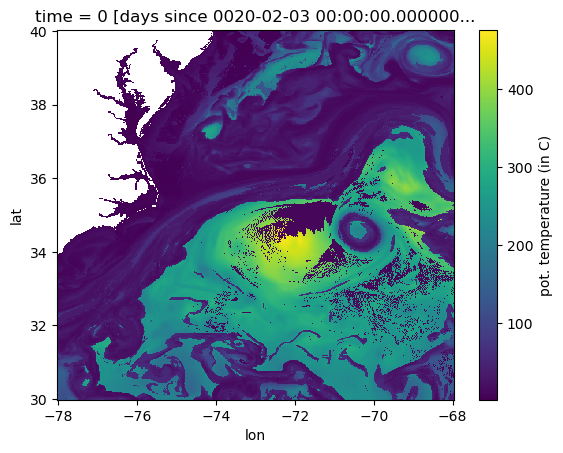

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [11]:
l10 = 2    # grid index of ~10m depth
MLD = xr.ones_like(dsi.t3.isel(lay=0)).load()

for i in range(len(dsi.time)):
    nMLD = (l10 
            + np.abs((sig0.isel(time=i,lay=slice(l10,None)).fillna(0.)
                      - sig0.isel(time=i,lay=l10).fillna(0.)
                     ) - .03
                    ).reset_coords(drop=True).argmin(dim='lay',skipna=True
                                                    ).compute()  # indexing needs loading
           )
    MLD[dict(time=i)] = dsi.Z.where(dsi.Z>0.).isel(time=i)[{'lay':nMLD}
                                                          ].chunk({'lat':200,'lon':200})
    if i == 0:
        MLD.isel(time=i).plot()
        plt.show()
    del nMLD
    print(i)

In [13]:
MLD.to_dataset(name='H'
              ).chunk({'time':3,'lat':100,'lon':100}
                     ).to_zarr(op.join(sdir,'HYCOM50/region%02d/MLD_fma.zarr'
                                       % 1), mode='w')